# EDA PROJECT - UK Vaccinations Dataset

Candidate No.565217

## INTRODUCTION

In recent years, the demand to get vaccinated is more crucial due to the COVID-19 pandemic. Therefore, it is significantly important for the vaccination centres to predict the number of people who will come on a specific day so they can prepare better. This report will focus on the dataset of all three doses to look for the primary trend among them and find the most optimal model to forecast the number of people who are vaccinated on a certain date.

## Part 1: Descriptive statistics and main trends.

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from bokeh.io import output_notebook
output_notebook()

from bokeh.plotting import figure
from bokeh.io import show
#magic function for diplaying plot in the notebook
%matplotlib inline 

Loading BokehJS ...

In [2]:
#Read the UK_VaccinationsData.xlsx file
df = pd.read_excel("UK_VaccinationsData.xlsx")
#Get the first three row of the data set
df.head(3)

,areaName,areaCode,year,month,Quarter,day,WorkingDay,FirstDose,SecondDose,ThirdDose
0,England,E92000001,2022.0,5,Q2,Mon,Yes,3034.0,3857.0,8747.0
1,England,E92000001,2022.0,5,Q2,Sun,No,5331.0,3330.0,4767.0
2,England,E92000001,2022.0,5,Q2,Sat,No,13852.0,9759.0,12335.0


In [3]:
# Generate descriptive statistics for the data set
df.describe().round(2)

,year,month,FirstDose,SecondDose,ThirdDose
count,903.00,904.00,900.00,901.00,898.00
mean,2021.63,5.95,4994.32,5574.13,42529.57
std,0.48,4.15,9651.34,9174.10,104877.58
min,2021.00,1.00,0.00,0.00,0.00
25%,2021.00,2.00,338.50,478.00,1313.50
50%,2022.00,4.00,876.50,971.00,6992.00
75%,2022.00,11.00,3653.25,5770.00,23464.75
max,2022.00,12.00,115551.00,48491.00,830403.00


In [4]:
#Find the total number of people took each dose
print(f'{int(df["FirstDose"].sum())} people took the first dose')
print(f'{int(df["SecondDose"].sum())} people took the second dose')
print(f'{int(df["ThirdDose"].sum())} people took the third dose')

4494891 people took the first dose
5022287 people took the second dose
38191554 people took the third dose


First and foremost, the count values of all five variables are different from each other, which means there are some missing values in the dataset. Next, the data can be considered the latest because more than half of the dataset is recorded in 2022. Moreover, ThirdDose has the least number of data entries, but its mean and sum are the largest among the three variables. It is resulted from the fact that the government urges people to take a total of three doses to prevent COVID-19.

# Part 2: Missing values and How to handle

In [5]:
#Get the info about the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   areaName    904 non-null    object 
 1   areaCode    904 non-null    object 
 2   year        903 non-null    float64
 3   month       904 non-null    int64  
 4   Quarter     903 non-null    object 
 5   day         903 non-null    object 
 6   WorkingDay  902 non-null    object 
 7   FirstDose   900 non-null    float64
 8   SecondDose  901 non-null    float64
 9   ThirdDose   898 non-null    float64
dtypes: float64(4), int64(1), object(5)
memory usage: 70.8+ KB


In [6]:
#Filling missing data of FirstDose by using interpolate linear method

df["FirstDose"].interpolate(method = "linear", inplace=True)

#Using rounding up function 
#because the number of first dose must be an integer

df["FirstDose"] = df["FirstDose"].apply(lambda x: math.ceil(x))

In [7]:
#Filling missing data of SecondDose by using interpolate linear method

df["SecondDose"].interpolate(method = "linear", inplace=True)

#Using rounding up function 
#because the number of second dose must be an integer

df["SecondDose"] = df["SecondDose"].apply(lambda x: math.ceil(x))

In [8]:
#Filling missing data of ThirdDose by using interpolate linear method

df["ThirdDose"].interpolate(method = "linear", inplace = True)

#Using rounding up function 
#because the number of the third dose must be an integer

df["ThirdDose"] = df["ThirdDose"].apply(lambda x: math.ceil(x))

In [9]:
#Filling missing data of Year by using interpolate linear method

df["year"].interpolate(method = "linear", inplace=True)

#Using rounding down function because the year must be an integer

df["year"] = df["year"].apply(lambda x: math.floor(x))

In [10]:
#Define function to get quarter from month collumn for missing values

def get_quarter(month):
    # Case of the first quarter of the year
    if month in [1, 2, 3]:
        return "Q1"
    # Case of the second quarter of the year
    elif month in [4, 5, 6]:
        return "Q2"
    # Case of the third quarter of the year
    elif month in [7, 8, 9]:
        return "Q3"
    # Case of the fourth quarter of the year
    elif month in [10, 11, 12]:
        return "Q4"

#Apply the get_quarter function to get the missing quarter value

df.loc[df["Quarter"].isnull(), 
       "Quarter"] = df.loc[df["Quarter"].isnull(), 
                           "month"].apply(get_quarter)

In [11]:
#Define a function to convert weekday names into a number

def day_num(x):
    #Set a list of days in a week
    weekdays = ["Sun","Sat","Fri","Thu","Wed","Tue","Mon"]
    #Get the index of each day in the list above
    if x in weekdays:
        y = weekdays.index(x)
        return y

#Add one column to find the missing day value
#Apply the day_num function above to fill the value in this column

df["day_num"] = df["day"].apply(day_num)

#Define a function to get the day_num of the missing day 
#based on the previous day

def next_day_num(x):
    #Using modulo operator to return the value
    return (x+1)%7

#Create a loop to fill the missing value by using the function next_day_num

for i in range(1,len(df)):
    #For the missing value only in the dataframe
    if pd.isna(df.at[i, "day_num"]):
        #Apply the function next_day_num
        df.at[i, "day_num"] = next_day_num(df.at[i-1, "day_num"])

#Define a function to convert day_num back to weekday name

def get_day_from_num(x):
    #Set a list of days in a week
    weekdays = ["Sun","Sat","Fri","Thu","Wed","Tue","Mon"]
    #Return the day from day_num variable
    return weekdays[int(x)]

#Apply get_day_from_num to get the missing values in the day

df.loc[df["day"].isnull(), 
       "day"] = df.loc[df["day"].isnull(), 
                       "day_num"].apply(get_day_from_num)

#Delete the day_num collumn

df = df.drop("day_num", axis =1)

In [12]:
#Define function to check working day for missing values

def working_day_check(day):
    #Check with weekdays to return Yes
    if day in ["Mon","Tue","Wed","Thu","Fri"]:
        return "Yes"
    #Check with the weekend to return No
    elif day in ["Sat","Sun"]:
        return "No"
    
#Apply working_day_check function 
#to get missing values in working day collumns

df.loc[df["WorkingDay"].isnull(), 
       "WorkingDay"] = df.loc[df["WorkingDay"].isnull(), 
                              "day"].apply(working_day_check)

In [13]:
#Double check the result table of information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   areaName    904 non-null    object
 1   areaCode    904 non-null    object
 2   year        904 non-null    int64 
 3   month       904 non-null    int64 
 4   Quarter     904 non-null    object
 5   day         904 non-null    object
 6   WorkingDay  904 non-null    object
 7   FirstDose   904 non-null    int64 
 8   SecondDose  904 non-null    int64 
 9   ThirdDose   904 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 70.8+ KB


## Part 3: Visualisation

### 3A. The distribution of SecondDose

Text(0.5, 1.0, 'Distribution of SecondDose')

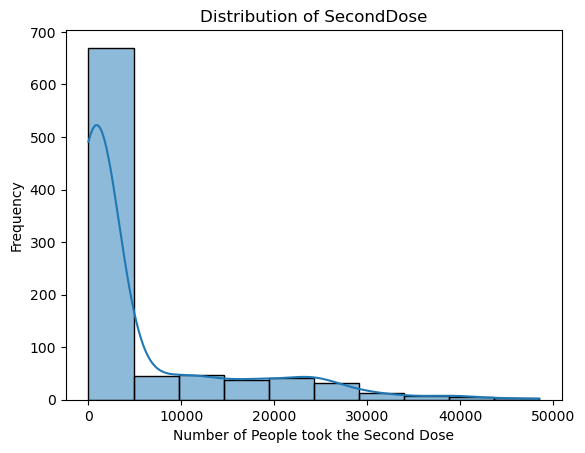

In [14]:
#Plot a histogram because this is the best graph 
#to display the distribution of a continuous variable

sns.histplot(df["SecondDose"], 
             bins = 10,
             kde = True)
#Naming x-axis, y-axis and graph title
plt.xlabel("Number of People took the Second Dose");
plt.ylabel("Frequency");
plt.title("Distribution of SecondDose")

First and foremost, this histogram is unimodal, which means it has one single dominant peak. Secondly, the distribution is right-skewed, with its peak on the left of the centre. Besides, the long tail on the right reveals numerous days when many people take their vaccine dose for the second time. 

### 3B. The relationship between FirstDose and SecondDose

Text(0.5, 1.0, 'Relationship between FirstDose and SecondDose')

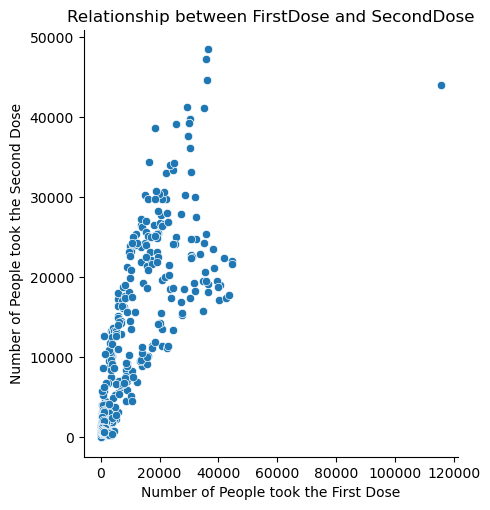

In [15]:
#Plot a scatter plot because it is the best graph 
#to reveal the relationship of two continuous variables

sns.relplot(x = "FirstDose", 
            y = "SecondDose", 
            data = df);

#Naming x-axis, y-axis and graph title
plt.xlabel("Number of People took the First Dose");
plt.ylabel("Number of People took the Second Dose");
plt.title("Relationship between FirstDose and SecondDose")

Firstly, there is a strong positive correlation between FirstDose and SecondDose because there is only a small number of outliers while most of the dots stay close to each other. Next, the steep slope indicates that the higher the number of people who take the first dose, the higher the number of people who take the second dose in a day.

### 3C. The association between Quarter and FirstDose

Text(0.5, 1.0, 'Association between Quarter and SecondDose')

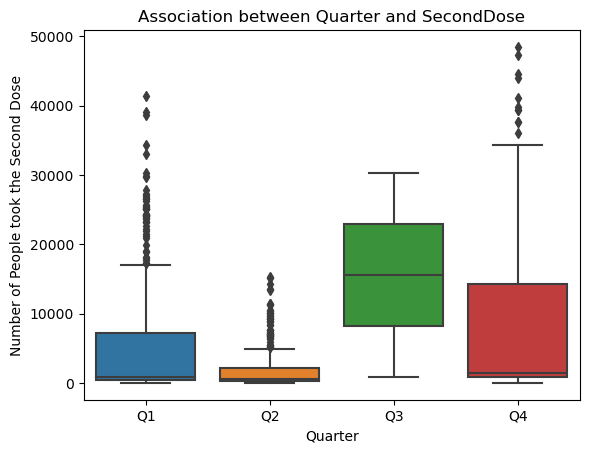

In [16]:
#Draw a box plot because it is the best 
#to display the association between a categorical and a continuous variable

sns.boxplot(x = "Quarter", 
            y = "SecondDose",
            order = ["Q1", "Q2", "Q3", "Q4"],
            data = df)

#Naming x-axis, y-axis and graph title

plt.xlabel("Quarter");
plt.ylabel("Number of People took the Second Dose");
plt.title("Association between Quarter and SecondDose")

The box plot reveals that the first, second, and fourth quarters have nearly the same distribution with a small range of values and many extreme outliers. In addition, they also witnessed the median values close to the lowest point of the data set, which means their distribution will be right-skewed. Moreover, the third quarter is the only one with no extreme outliers and the highest median. Besides, its median is also at the centre of the interquartile box, which is opposite to all other quarters. Therefore, the number of people who took the second dose was symmetrically distributed in the third quarter.

### 3D. The relationship between SecondDose, ThirdDose, and Year

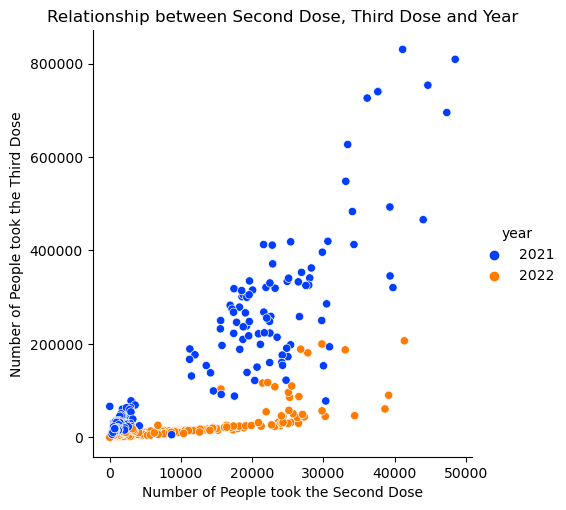

In [17]:
#Build graphs visualizing the relationship between three variables 
#using semantic mappings

ax = sns.relplot(x = "SecondDose", 
                 y = "ThirdDose",  
                 hue = 'year', 
                 palette = "bright",
                 data = df)

#Naming x-axis, y-axis and graph title

ax.set(xlabel = "Number of People took the Second Dose", 
       ylabel = "Number of People took the Third Dose",
       title = "Relationship between Second Dose, Third Dose and Year")

The scatter plot above reveals that the relationship between SecondDose and ThirdDose is a moderate positive relationship in both 2011 and 2022. However, the ThirdDose's stat in 2021 is significantly higher than 2022's, which can be the effect of the urgency to get vaccinated when the COVID-19 outbreak.

## Part 4: Display unique values and frequencies of Quarter

In [18]:
#Display unique values of Quarters and their frequencies

df["Quarter"].value_counts()

Q1    360
Q4    336
Q2    206
Q3      2
Name: Quarter, dtype: int64

Third quarter is the only period that has a significantly low number of data, below 200 entries. It indicates that the amount of data collected is insufficient to conclude about the distribution of vaccinated citizens in every quarter. Furthermore, it is also helpful for the regression model in part 9 later in choosing independent variables.

## Part 5: The Relationship between Day and WorkingDay

In [19]:
#Use the crosstab function to build the contigency table

cont_table = pd.crosstab(df["day"], 
                         df["WorkingDay"])

#Get the contingency table

cont_table

WorkingDay,No,Yes
day,,
Fri,0,130
Mon,0,129
Sat,130,0
Sun,130,0
Thu,0,130
Tue,0,127
Wed,0,128


Step 1:
- The Null hypothesis is that there is no dependence between day and WorkingDay. 
- The Alternative hypothesis is that there is a dependence between day and WorkingDay.

Step 2: To test whether two categorical variables are independent or not, it is required to use the Chi-square test

Step 3: For the Chi-square test, the usual significance level used is 0.05. Therefore, the value of $\alpha$ to compare is 0.05

Step 4: Calculate the test statistic

In [20]:
#Calculate the chi-square test statistic

chi2, p_val, dof, expected = stats.chi2_contingency(cont_table)

#Print the value of p-value

print(f"p-value: {p_val}")

p-value: 5.129354374464748e-192


Step 5: The p-value obtained from the Chi-square test is smaller than the $\alpha$ chosen of 0.05. Therefore, we reject the null hypothesis that there is no dependence between day and WorkingDay. In other words, we found evidence that the day and WorkingDay variables depend on each other.

## Part 6: Descriptive statistics of the subset  for England and Working day only.

In [21]:
#Create a subset called df1
#with the areaName is England only and WorkingDay equals Yes
df1 = df[df.areaName == "England"][df.WorkingDay == "Yes"]

#Get the descriptive statistics of the df1 subset
df1.describe().round(2)

/var/folders/js/r_0gjgwj091d92n_f7mxb7rc0000gp/T/ipykernel_37423/4023301856.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df.areaName == "England"][df.WorkingDay == "Yes"]


,year,month,FirstDose,SecondDose,ThirdDose
count,168.00,168.00,168.00,168.00,168.00
mean,2021.60,6.14,17777.57,18739.35,140651.35
std,0.49,4.15,13890.40,9274.03,170884.74
min,2021.00,1.00,2925.00,2246.00,3193.00
25%,2021.00,3.00,7088.25,11231.75,14879.75
50%,2022.00,4.00,15058.00,18704.50,44283.50
75%,2022.00,11.00,25373.25,24411.50,240173.00
max,2022.00,12.00,115551.00,48491.00,809192.00


The most important thing obtained is the fact that the mean approximately equals the median in all three numerical variables. It indicates that the distribution of FirstDose, SecondDose, and ThirdDose in England on working days is closely symmetric.

## Part 7: The Difference between the Mean of FirstDose in England and Wales

In [22]:
#Get the data of FirstDose with areaName == "England"
first_england = df[df["areaName"] == "England"]["FirstDose"]

#Calculate the fist_england mean
first_england.mean()

16869.427966101695

In [23]:
#Get the data of FirstDose with areaName == "Wales"
first_wales = df[df["areaName"] == "Wales"]["FirstDose"]

#Calculate the fist_wales mean
first_wales.mean()

663.047619047619

Step 1:

- The null hypothesis is that the difference between the two population means equals 0 ($H_0: \mu = 0$)

- The alternative hypothesis is that the mean of FirstDose in England is significantly lower or higher than the mean of FirstDose in Wales. ($H_A: \mu \ne 0$)

Step 2: For this case, the independent two-sample t-test will be used due to the fact that we have two unrelated test sample.

Step 3: For the independent two-sample t-test test, the usual significance level used is 0.05.

Step 4: Calculate the test statistic

In [24]:
t_val, p_val = stats.ttest_ind(first_england, 
                               first_wales)

print(f"t-value: {t_val}, p-value: {p_val}")

t-value: 18.39925041256226, p-value: 1.3188267434471777e-56


Step 5: The p-value obtained is smaller than the $\alpha$ chosen of 0.05. Therefore, we reject the null hypothesis that the difference between the two population means equals 0. In other words, the difference between the mean of the first_england and first_wales sample is not equal to 0.

## Part 8: Summarized Information for each area

In [25]:
#Group the dataset by "areaName"
#get the mean and sum of each Dose variable

df.groupby("areaName")["FirstDose", 
                       "SecondDose", 
                       "ThirdDose"].aggregate(["mean", 
                                               "sum"]).round(2)

/var/folders/js/r_0gjgwj091d92n_f7mxb7rc0000gp/T/ipykernel_37423/2070789406.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("areaName")["FirstDose",


FirstDose          SecondDose           ThirdDose          
                      mean      sum       mean      sum       mean       sum
areaName                                                                    
England           16869.43  3981185   18469.02  4358688  136262.10  32157855
Northern Ireland    496.45   117163     574.75   135641    4787.11   1129759
Scotland           1170.59   259872    1569.13   348347   14780.53   3281277
Wales               663.05   139240     870.53   182812    8411.21   1766355

The table above reveals the summarized information for each area in the dataset. For instance, England has the highest mean and total number in terms of all three doses, which results from its extremely high population compared to other regions.

## Part 9: Linear Regression Model

Before forming a multiple linear regression model, we need to investigate further the correlation between independent variables to reduce the multicollinearity possibility in the final model. There are some potential pairs of variables below that need to be checked:

- Day and Workingday:

These two variables have been proved to be dependent in part 5 earlier so only one of two will be selected for our model. To get the most parsimonious model, we will use workingday as one of the dummy variables with one stands for a working day and 0 stands for a non-working day. The function below will convert from workingday to the dummy variable, WorkingDay.

In [26]:
#Define a function to return a dummy variable for WorkingDay
def Workingday_Convert(x):
    #If it is a working day
    if x == "Yes":
        return 1
    #If it is not a working day
    else:
        return 0
#Create a new column for the dummy variable of WorkingDay 
#by apply the above function
df["workingday"] = df["WorkingDay"].apply(Workingday_Convert)

- Quarter and Month:

In [27]:
#Define a function to return the integer number of each quarter
def quarter_convert(x):
    #Return the integer number of each quarter
    return int(x[-1])

#Create a new column for the quarter value by apply the above function
df["quarter"] = df["Quarter"].apply(quarter_convert)

#Get the Pearson correlation coefficient between month and quarter
df['month'].corr(df['quarter'], 
                 method='pearson')

0.9814036970855782

From the result obtained, there is a significant relationship between month and quarter. Therefore, only one will be considered in the final model. As mentioned in part 4, there is a lack of data in the third quarter, so month will be the selected one.

Besides, based on the data from part 8, areaName can be converted into a dummy variable with 1 stands for England for its extremely high population and 0 stands for the other three regions:

In [28]:
#Define a function to return a dummy variable for areaName
def areaName_Convert(x):
    #If it is England
    if x == "England":
        return 1
    #If it is not England:
        return 0
#Apply the function above to convert Area into dummy variables
df["Area"] = df["areaName"].apply(areaName_Convert)

Finally, the dependent variable is the daily total number of vaccinated people. It can be calculated by taking the sum of all three doses variable in each day:

In [29]:
#Create a variable represents the daily total number of vaccinated people
df["TotalPeople"] = df["FirstDose"] + df["SecondDose"] + df["ThirdDose"]

To summarise, the final model will have "TotalPeople" as the dependent variable and the independent variables are: "Area", "year", "month", and "workingday".

In [30]:
#Create a linear regression model
model = sm.OLS.from_formula(
    'TotalPeople ~ Area + year + month + workingday', data=df).fit()
#Call out the summary table of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalPeople   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     113.2
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           3.51e-45
Time:                        22:40:05   Log-Likelihood:                -3093.6
No. Observations:                 236   AIC:                             6195.
Df Residuals:                     232   BIC:                             6209.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.717e+08   5.58e+07      4.869      0.000    1.62e+08    3.82e+08
Area        2.717e+08   5.58e+07      4.869      0.000    1.62e+08    3.82e+08
year       -2.688e+05   5.52e+04     -4.869      0.000   -3.78e+05    -1.6e+05
month       3220.7072   6540.043      0.492      0.623   -9664.760    1.61e+04
workingday  1.432e+04   1.73e+04      0.828      0.409   -1.98e+04    4.84e+04
==============================================================================
Omnibus:                      113.335   Durbin-Watson:                   0.407
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              585.982
Skew:                           1.883   Prob(JB):                    5.70e-128
Kurtosis:                       9.739   Cond. No.                     6.82e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.07e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Here is the final model to predict the number of people vaccinated in a day:

$TotalPeople = 271,700,000 + 271,700,000*Area - 268,800*year + 3,220.7072*month + 14,320*workingday$

**1) Coefficient of variables:**

Based on the sign of these coefficients, it is clear to state that year has a negative influence on TotalPeople. The higher the year is, the smaller the total people is. Meanwhile, all others have a positive impact on the dependent variable. For example, if it is a working day, the number of vaccinated people will rise by 14,320 compared with a non-working day.

**2) Significance of variables:**

The p-values of all variables are significant, except for the month and workingday. Therefore, Area and year have significant effects on the total number of people vaccinated in a day, while month and workingday do not. 

**3) Quality of the model:**

The adjusted $R^2$ is approximately 0.59, which indicates the model only helps to explain 59% of the total number of dependent values obtained in the dataset. With this result from the adjusted $R^2$, it can be considered a good model to predict the dependent variables. However, before coming to a conclusion, it is necessary to test the assumptions of normality and zero mean of the residuals.

**4) Checking the assumptions of normality and zero mean of residuals:**
    
    a. Standardized Residuals:

In [31]:
#Create a space to plot the residual distribution around 0 chart
fig = figure(height=400, 
             width=400)

# the x axis is the fitted values
# the y axis is the standardized residuals
st_resids = model.get_influence().resid_studentized_internal

fig.circle(model.fittedvalues, 
           st_resids)

#Show the chart
show(fig)

The above plot displays the distribution of residuals around 0. To elaborate. the residuals in this graph are not distributed equally around 0 because there is a certain pattern of the dots inside the diagram.

    b. Residuals Distribution:

In [32]:
# create a histogram with 10 bins
hist, edges = np.histogram(st_resids, 
                           bins=10)

fig = figure(height=400, 
             width=400)

fig.quad(top=hist, 
         bottom=0, 
         left=edges[:-1], 
         right=edges[1:], 
         line_color="white")

#Show the chart
show(fig)

According to the scatter plot, the histogram and the JB test, this model violates the normality assumptions. To elaborate, the probability of JB in the JB test is 5.70e-128, which is extremely smaller than the significance level of 0.05. Therefore, the null hypothesis of normal distribution is rejected. Besides, the residual distribution in the scatter plot is not normal.

**According to the results obtained from the model, we can say that this model is not useable to predict the number of people who get vaccinated in a day.**

# Conclusion

All in all, from the dataset provided, it is unable to conduct an appropriate regression model to predict the total number of people who get vaccinated in a day. However, there are some key findings as follows:
- 2022 witnessed a considerable decrease in the number of vaccinated people compared to 2021 because there are a lot of citizens who already finished the three-dose in 2021 and COVID-19 stopped its outbreak at the beginning of 2022.
- The dataset is insufficient due to the lack of data in the third quarter.
- There are some pairs of variables in the dataset that are highly correlated: Day and Working day; Month and Quarter

In [33]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [34]:
import io
from nbformat import read, NO_CONVERT

with io.open(NOTEBOOK_FULL_PATH.split("/")[-1], 'r', encoding='utf-8') as f:
    nb = read(f, NO_CONVERT)

word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print(f"Word count: {word_count}")

Word count: 1624
